In [1]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers
import tensorflow as tf
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = '2015-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)



Tensorflow Version: 2.10.0
Num GPUs: 0
[*********************100%%**********************]  1 of 1 completed
(2172, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


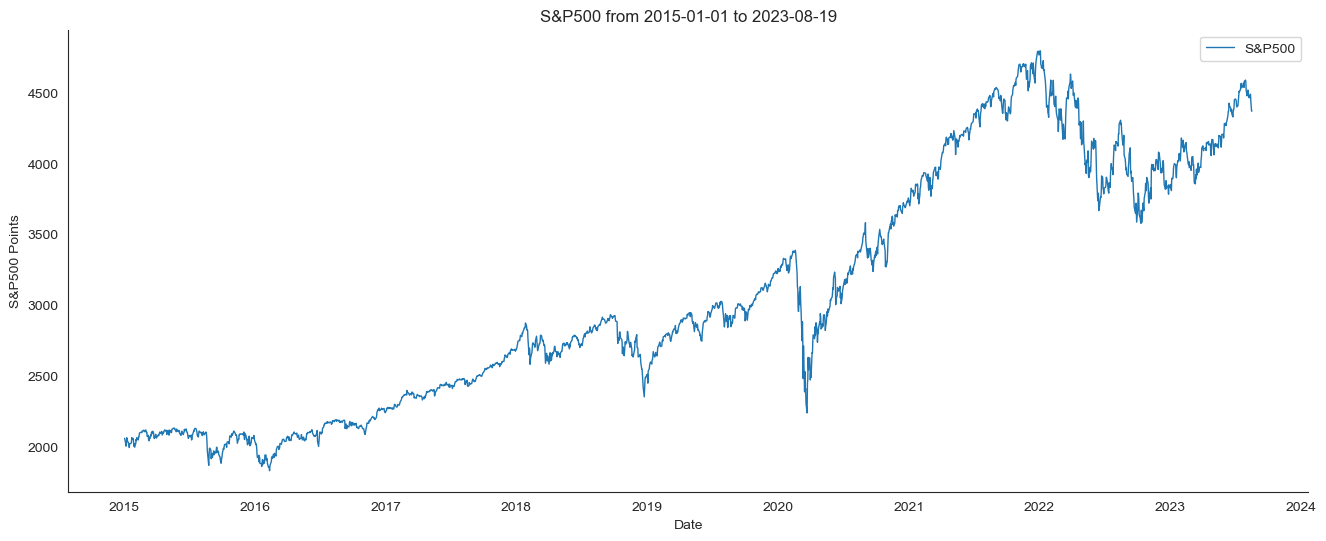

In [3]:
# Creating a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['Close'], label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points')
plt.show()

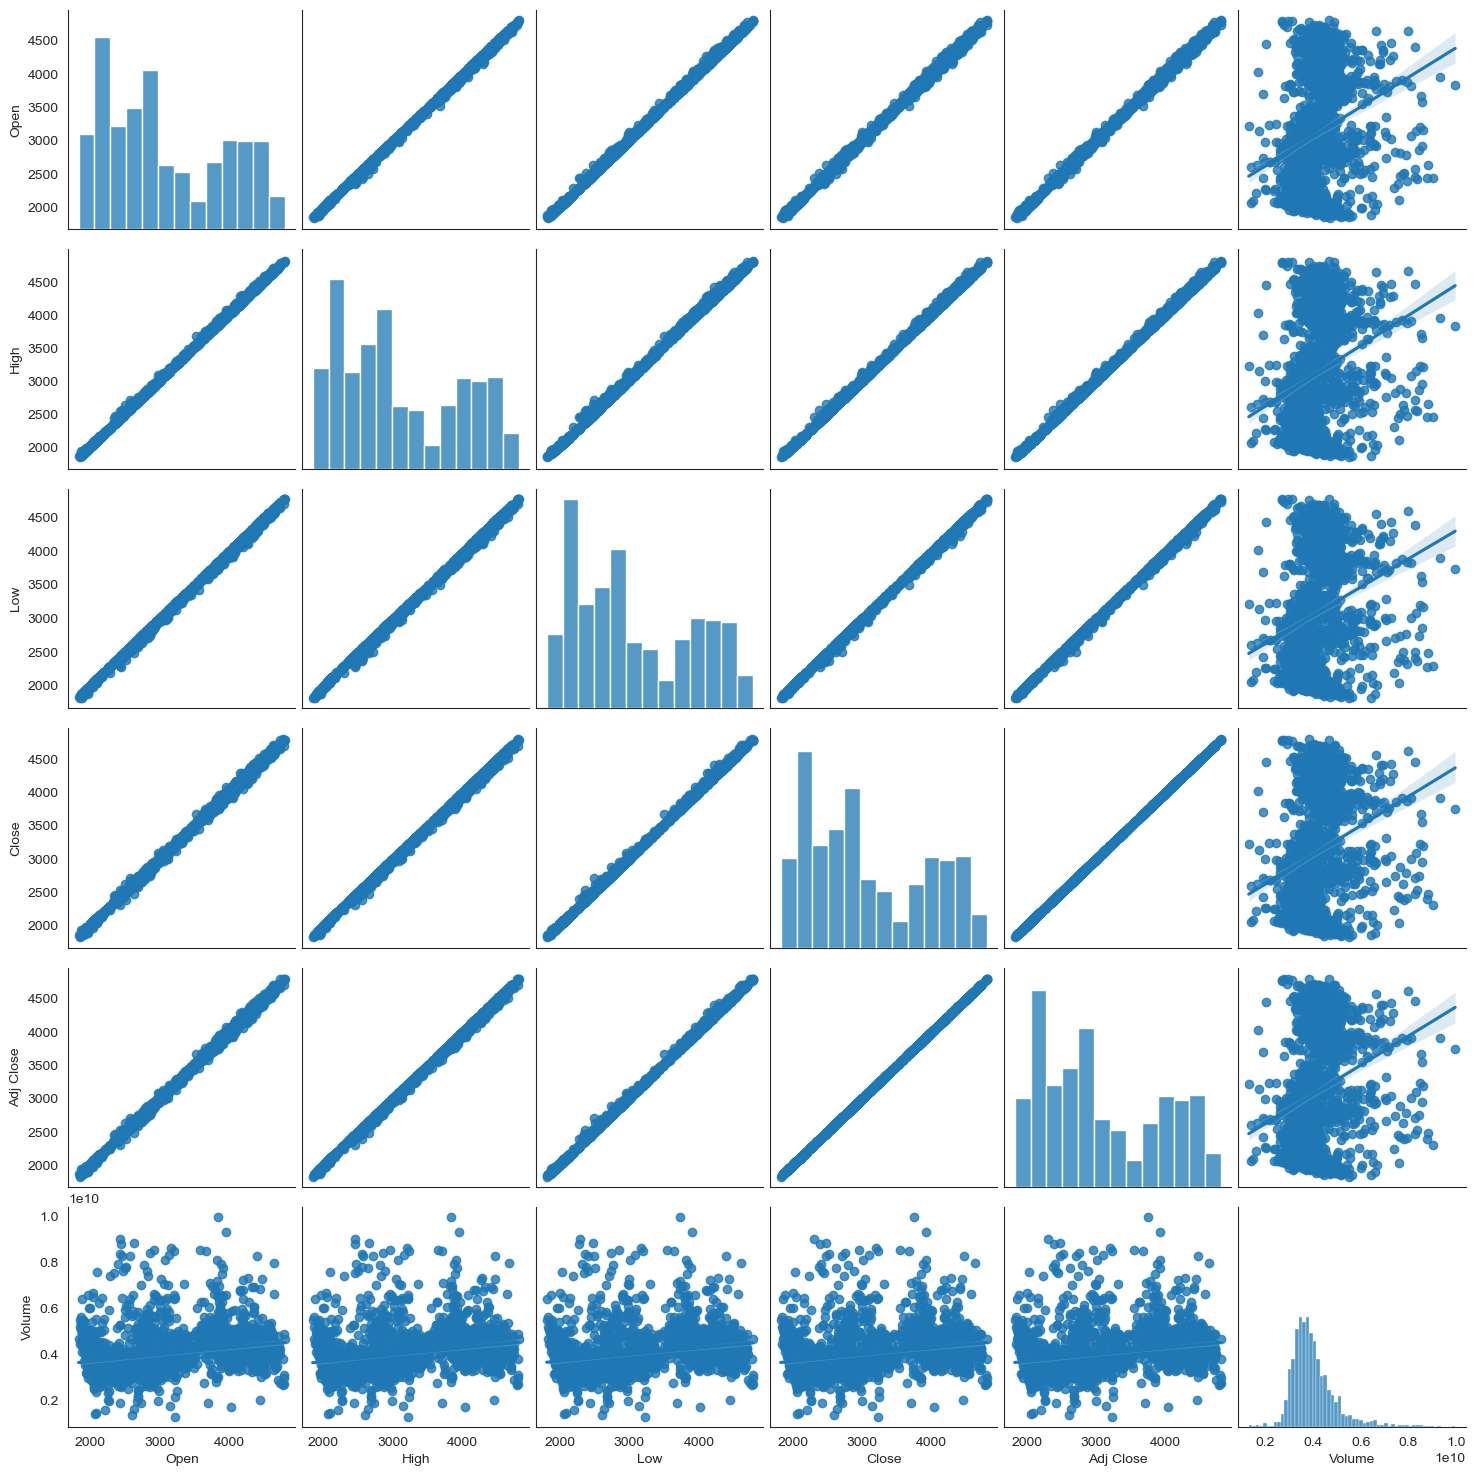

In [4]:
sns.pairplot(df, kind='reg')


In [5]:
# Feature Selection - Only Close Data
train_df = df.filter(['Close'])
data_unscaled = train_df.values

# Get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(len(data_unscaled) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = train_df.columns.get_loc("Close")
print(index_Close)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) 
        y.append(train_df[i, index_Close]) ediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0
(1688, 50, 1) (1688,)
(434, 50, 1) (434,)
0.9319490158557544
0.9319490158557544


In [7]:
# Configure the neural network model
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(35, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Training the model
model.fit(x_train, y_train, batch_size=8, epochs=25)

Epoch 1/25
211/211 [==============================] - 7s 17ms/step - loss: 0.0054
Epoch 2/25
211/211 [==============================] - 4s 18ms/step - loss: 6.6372e-04
Epoch 3/25
211/211 [==============================] - 4s 18ms/step - loss: 6.4892e-04
Epoch 4/25
211/211 [==============================] - 4s 18ms/step - loss: 5.5336e-04
Epoch 5/25
211/211 [==============================] - 4s 18ms/step - loss: 4.6926e-04
Epoch 6/25
211/211 [==============================] - 4s 18ms/step - loss: 4.2220e-04
Epoch 7/25
211/211 [==============================] - 4s 20ms/step - loss: 3.7598e-04
Epoch 8/25
211/211 [==============================] - 4s 18ms/step - loss: 4.6057e-04
Epoch 9/25
211/211 [==============================] - 4s 18ms/step - loss: 3.6723e-04
Epoch 10/25
211/211 [==============================] - 4s 19ms/step - loss: 3.1911e-04
Epoch 11/25
211/211 [==============================] - 4s 18ms/step - loss: 3.1760e-04
Epoch 12/25
211/211 [==============================] - 4

In [9]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

14/14 [==============================] - 1s 12ms/step


In [16]:

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

"""
    Calculate the Root Mean Squared Error (RMSE)
    """
rmse = np.sqrt(np.mean((y_test_unscaled - y_pred) ** 2))
print(f'Root Mean Square Error (RMSE): {np.round(rmse, 2)}')



Median Absolute Error (MAE): 44.93
Mean Absolute Percentage Error (MAPE): 1.09 %
Median Absolute Percentage Error (MDAPE): 0.88 %
Root Mean Square Error (RMSE): 56.86


In [11]:
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Close': 'x_train'})
train

,x_train
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
...,...
2021-11-19,4697.959961
2021-11-22,4682.939941
2021-11-23,4690.700195


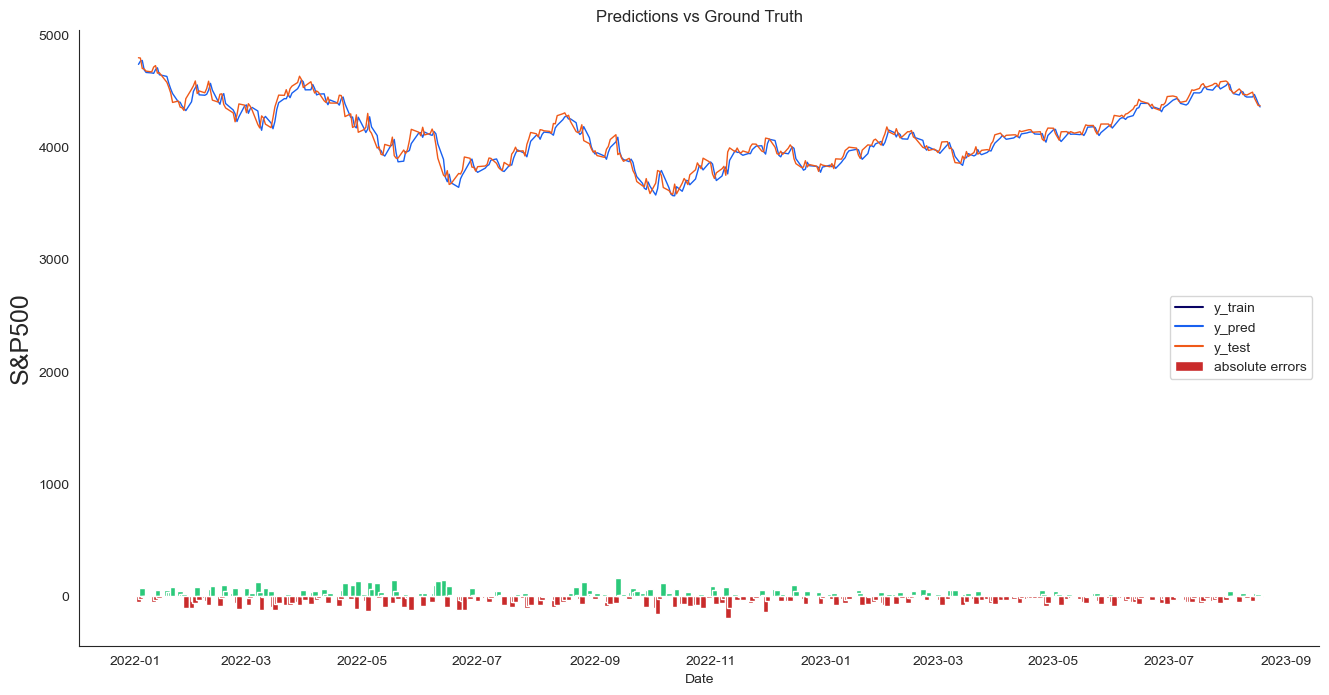

In [19]:
# The date from which on the date is displayed
display_start_date = "2022-01-01" 
# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df[train_data_length:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Ground Truth")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the barplot for the absolute errors
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [20]:
# Get fresh data
df_new = df.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent_change = round((predicted_price * 100)/price_today - 100, 2)

prefix = '+' if percent_change > 0 else ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price for the next day is {predicted_price} ({prefix}{percent_change}%)')

1/1 [==============================] - 0s 75ms/step
The close price for S&P500 at 2023-08-19 was 4369.71
The predicted close price for the next day is 4356.9599609375 (-0.29%)


In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 35)                1785      
                                                                 
 dense_1 (Dense)             (None, 1)                 36        
                                                                 
Total params: 32,421
Trainable params: 32,421
Non-trainable params: 0
_________________________________________________________________
